In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import batsim.transforms as batforms
import numpy as np
import galsim
import matplotlib.pyplot as plt
import fpfs

from batsim.stamp import Stamp
from batsim.pltutil import stitch_images
from astropy.io import fits

from PIL import Image, ImageOps

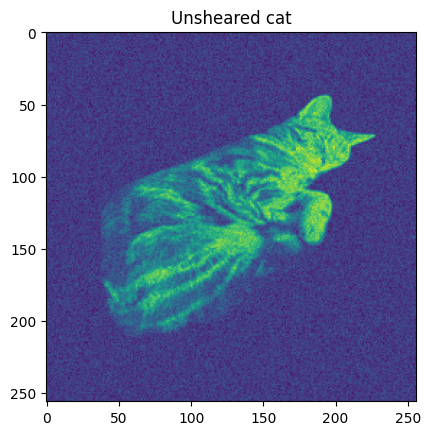

In [92]:
# Read in cat
cat_gal = galsim.InterpolatedImage("cat.fits", offset=[-20,40])
hlr = cat_gal.calculateHLR()

# noise
noise = galsim.GaussianNoise(rng=None, sigma=20.0)

cat_noshear = cat_gal.drawImage(nx=256, ny=256, scale=1)
cat_noshear.addNoiseSNR(noise, snr=1000)
plt.imshow(cat_noshear.array)
plt.title('Unsheared cat')
plt.savefig('cat_noshear')

In [93]:
#cat_gal = galsim.Sersic(n=1.4, half_light_radius=100).shear(e2=-0.3)

# ia transform
cat_stamp = Stamp(nn=256, scale=1)
lens = batforms.LensTransform(gamma1=0.02, gamma2=0, kappa=0)

cat_stamp.transform_grids(lens)

# Randomly rotate cat to cancel shape noise
ngal = 9

if np.sqrt(ngal) != int(np.sqrt(ngal)):
    raise ValueError("Choose a square number")
    
thetas = (np.pi / ngal) * np.arange(ngal) * galsim.radians

cat_ims = []
for i, th in enumerate(thetas):

    cat_rotate = cat_gal.rotate(th)
    cat_IA = cat_stamp.sample_galaxy(cat_rotate)
    
#     if i == 0:
#         cat_ims = cat_IA
#     else:
#         np.concatenate((cat_ims, cat_IA))

    cat_im = galsim.Image(cat_IA)
    cat_im.addNoise(noise)
    
    cat_ims.append(cat_im)

[3. 6. 9.]


Text(0.5, 1.0, 'Subset of WHiSQaS objects with various orientations')

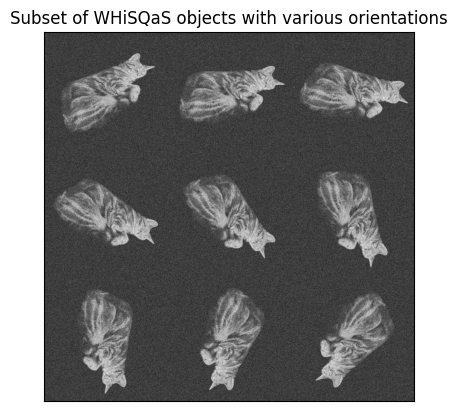

In [94]:
row_cats = []
indxs = np.sqrt(ngal) * np.arange(1,np.sqrt(ngal)+1)
print(indxs)
old = 0
for i in indxs:
    i = int(i)
    row_cats.append(stitch_images(cat_ims[old:i], direction='horizontal'))
    old = i 
    
all_cats = stitch_images(row_cats, direction='vertical')
plt.imshow(all_cats.array, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Subset of WHiSQaS objects with various orientations')

# fig, axs = plt.subplots(int(np.sqrt(ngal)),int(np.sqrt(ngal)), constrained_layout=True)
# fig.suptitle('Subset of WHiSQaS objects with various orientations')

# axs = axs.reshape(ngal)
# for i, ax in enumerate(axs):
#     ax.imshow(cat_ims[i].array, cmap='gray')
#     ax.set_xticks([])
#     ax.set_yticks([])

In [95]:
# define PSF
psf_array = np.zeros(all_cats.array.shape)
psf_array[256*int(np.sqrt(ngal)) // 2, 256*int(np.sqrt(ngal)) // 2] = 1

coords = np.array([256*int(np.sqrt(ngal)) //2, 256*int(np.sqrt(ngal)) //2])
fpTask = fpfs.image.measure_source(psf_array, pix_scale=1, sigma_arcsec=0.52)
mms = fpTask.measure(all_cats.array, coords)
mms = fpTask.get_results(mms)
ells = fpfs.catalog.fpfs_m2e(mms,const=1.43333333333333333333)
resp = np.average(ells['fpfs_R1E'])
shear = np.average(ells['fpfs_e1'])/resp
print("measured shear: %.6f" % shear)

2023/11/02 16:34:25 ---  Order of the shear estimator: nnord=4
2023/11/02 16:34:25 ---  Shapelet kernel in configuration space: sigma= 0.5200 arcsec
2023/11/02 16:34:25 ---  Detection kernel in configuration space: sigma= 0.5200 arcsec
2023/11/02 16:34:25 ---  Maximum |k| is 3.133


measured shear: -0.775345
